In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro
from astropy.cosmology import WMAP9 as cosmo
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries


%matplotlib notebook
import matplotlib.pyplot as plt


from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1,
            # grid='off'
            
            )
import seaborn as sns


from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import pystan
from vapeplot import vapeplot

vapeplot.set_palette('vaporwave')

In [2]:
def dNdz(z,r0,a, b):
    
    return r0 * np.power(z+1,a) * np.exp(-z/b)
    

In [3]:
def draw_luminosity(mu, sigma, size=1):
    xs_all = np.exp(mu + sigma*np.random.randn(size))
    return xs_all

In [4]:
def draw_fobs(L,z, sigma,size=1):
    
    f = L/(4 * np.pi * z * z)
    
    return np.exp(np.log(f) + sigma*np.random.normal(size))

In [5]:
def draw_zs(r0, alpha, beta, zmax):
    zs = np.linspace(0, zmax, 1000)
    dndzs = dNdz(zs, r0, alpha, beta)
    ymax = np.max(dndzs)
    Nex = integrate.quad(dNdz,0.,zmax,args=(r0,alpha, beta))[0]
    Ndraw = np.random.poisson(Nex)
    igen = 0
    while igen < Ndraw:
        y = np.random.uniform(low=0, high=ymax)
        z = np.random.uniform(low=0, high=zmax)
        if y < dNdz(z, r0, alpha, beta):
            igen += 1
            yield z

In [16]:
def draw_survey(r0,a,b, mu, sigma, fsigma,zsigma,Fth, zmax):
    
    # first draw the redshifts
    zsample = np.array([z for z in draw_zs(r0, a, b, zmax)])
    
    n = len(zsample)
    
    Ls = draw_luminosity(mu, sigma, size=n)
    
    
    Fobs = draw_fobs(Ls, zsample,fsigma,size=n)
    
    
        
    sel = Fobs > Fth
    
    zobs = np.exp(np.log(zsample) + zsigma* np.random.normal(size=n))
  
    z99obs = np.percentile(zobs[sel], 99)
    
    print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    
    print(sum(sel), sum(~sel))

    return dict(Fobs=Fobs[sel],Ltrue=Ls,ztrue=zsample, zobs=zobs[sel],sel=sel)

In [18]:
np.random.seed(9128347)

r0_true = 20
a_true = 2.
b_true= 2.
mu_true = 1.
sigma_true = .1
Fth = .1/(4*np.pi)

Fsigma= .001
zsigma=.05
zmax = 10.
survey = draw_survey(r0_true,
                     a=a_true,
                     b=b_true,
                     mu=mu_true,
                     sigma=sigma_true,
                     fsigma=Fsigma,
                     zsigma=zsigma,
                     Fth=Fth,
                     zmax=zmax)






#selection = survey_df.sel

99th percentile of observed galaxy redshifts is 6.74
339 94


In [13]:
survey

{'Fobs': array([5.13982128e-02, 2.77685157e-01, 3.16396841e-02, 8.67528375e-03,
        6.31912666e-03, 1.45238933e-01, 6.71221880e-03, 2.11501643e-01,
        6.93295819e-03, 7.36149734e-03, 2.76028635e-02, 1.46301297e-02,
        2.10250848e-02, 5.24016159e-02, 1.20203829e-02, 1.87950865e-02,
        1.60577602e-01, 7.64959349e-03, 1.28773123e-02, 7.56151504e-02,
        2.07163384e-01, 4.29644748e-02, 1.53065659e-02, 1.15867790e-01,
        6.56338827e-03, 9.99073909e-03, 4.28371933e-02, 2.69109414e-02,
        2.25773434e-02, 3.76544536e-02, 4.54396110e-02, 6.83163828e-03,
        2.38225177e-02, 4.79318761e-03, 2.35235149e-02, 2.22023883e-02,
        9.58796185e-02, 1.02340089e-02, 1.74129138e-02, 5.04918578e-03,
        1.05581887e-02, 8.10044898e-03, 6.81419330e-03, 6.93757642e-01,
        1.86871694e-02, 9.05211873e-03, 5.54648634e-03, 6.17000950e-03,
        1.69982974e-02, 4.92442220e-02, 1.04237083e-02, 2.28747188e-01,
        2.37410976e-02, 4.30604603e-03, 1.00209356e-01, 

<IPython.core.display.Javascript object>


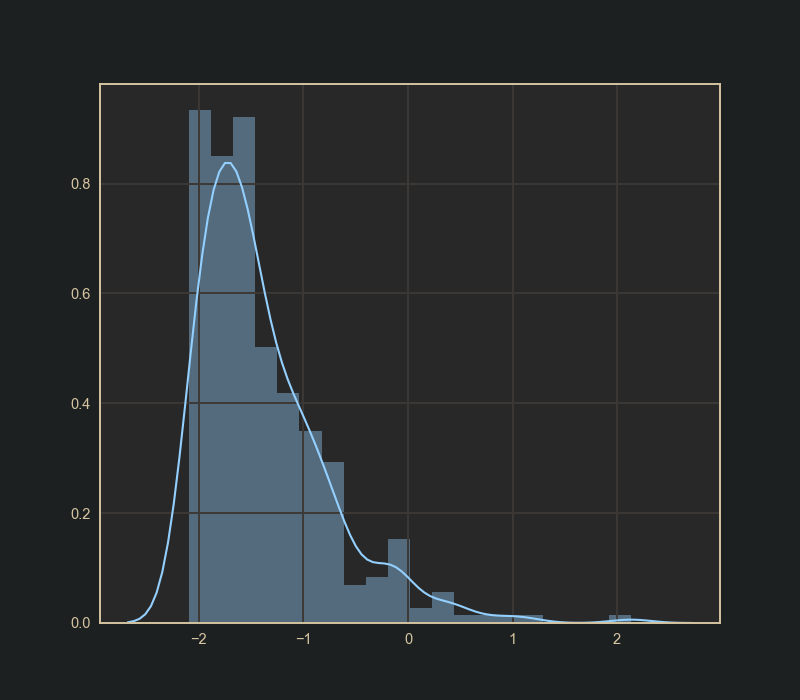

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [19]:
fig, ax = plt.subplots()


sns.distplot(np.log10(survey['Fobs']))


#ax.hist(np.linspace(0,100))

<IPython.core.display.Javascript object>


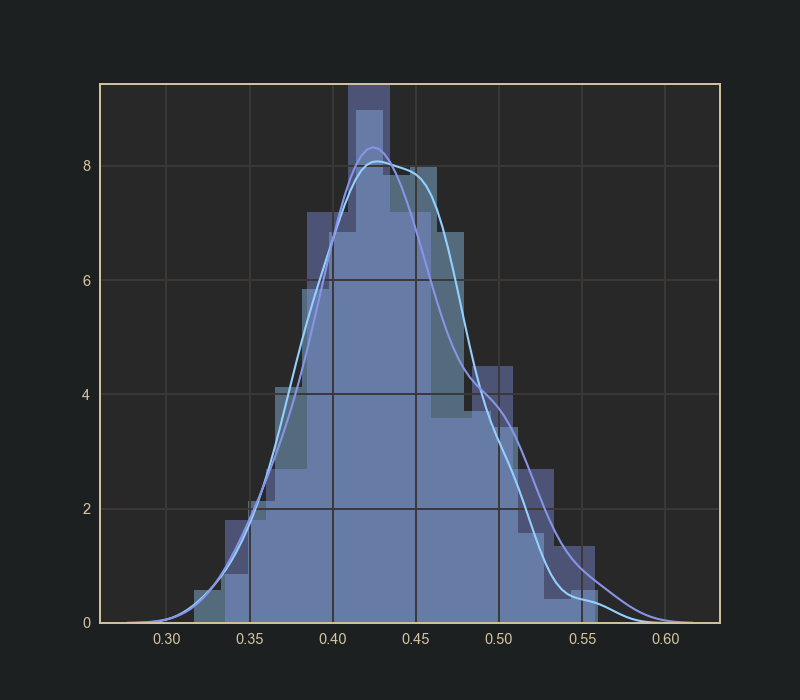

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [10]:
fig, ax = plt.subplots()

bins = np.linspace(-0,1,10)
sns.distplot(np.log10(survey['Ltrue']),
        #bins=bins
       )
sns.distplot(np.log10(survey['Ltrue'])[survey['sel']],
       # bins=bins
       )

<IPython.core.display.Javascript object>


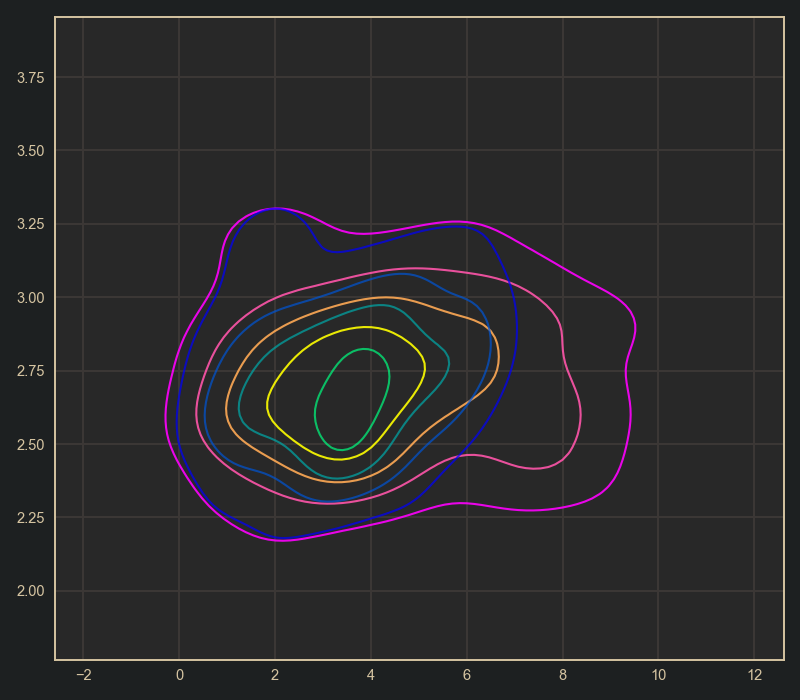

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


In [20]:
fig, ax = plt.subplots()


sns.kdeplot(
    survey['ztrue'],
    (survey['Ltrue']),
    
    
    shade=False,
    shade_lowest=False,
    
    cmap='spring',
    alpha=0.9,
    n_levels=4


);

sns.kdeplot(
    
    
    survey['ztrue'][survey['sel']],
    (survey['Ltrue'][survey['sel']]),
    
    shade=False,
    shade_lowest=False,
    
    cmap='winter',
    alpha=0.7,
    n_levels=4,
    linewidth=6


);




In [49]:
model = pystan.StanModel(file='flux.stan', model_name='flux_fit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL flux_fit_b44fe948550f78feb96fde07fadf9a51 NOW.


In [50]:
zmodel = np.linspace(0,10,500)

In [51]:
fit = model.sampling(
    data = {'Nobs': len(survey['zobs']), 
            'Fobs': survey['Fobs'],
            'zobs': survey['zobs'],
            'sigma_F_obs': Fsigma,
            'sigma_z_obs': zsigma,
            
            
            'Nnobs_max': 200,
            
            'Fth': Fth,
            'true_upper':10.,
            'meas_upper':15.,
            'zs_model': zmodel,
            'nmodel':500},
    iter = 4000,
    #warmup=3000,
    thin = 2,
    seed=194838
)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


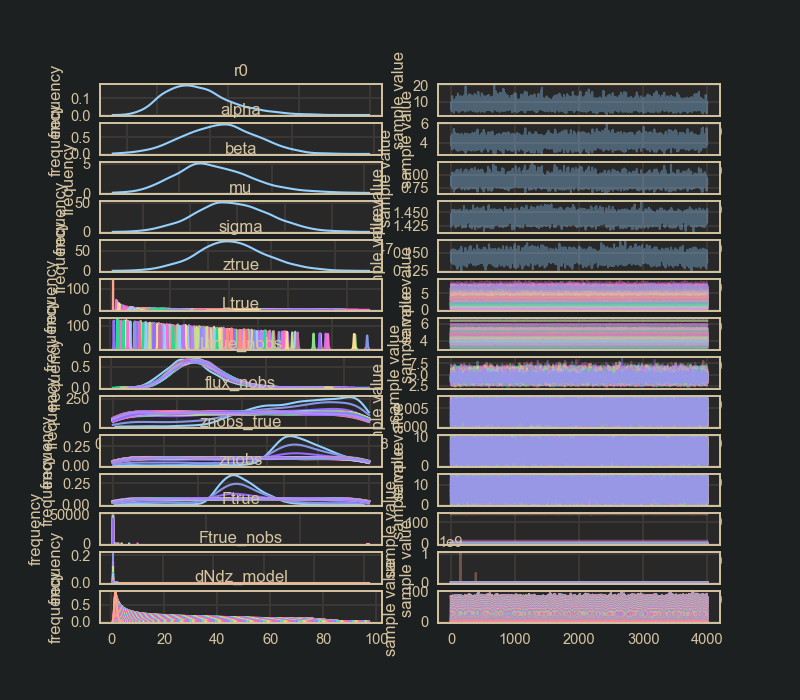

In [52]:


fit.plot();
#plt.tight_layout()

In [46]:
fit

Inference for Stan model: flux_fit_790c2fe2d478309e110789b546ed4880.
4 chains, each with iter=4000; warmup=2000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r0                7.76    0.05   2.27    4.1   6.14    7.5   9.15  12.68   2161    1.0
alpha             4.19  9.2e-3   0.45   3.35   3.88   4.18   4.49   5.11   2392    1.0
beta              0.86  1.4e-3   0.08   0.72   0.81   0.86   0.91   1.04   3209    1.0
mu                1.44  1.3e-4 7.8e-3   1.42   1.43   1.44   1.44   1.45   3378    1.0
sigma             0.14  1.3e-4 5.6e-3   0.13   0.14   0.14   0.15   0.16   1957    1.0
ztrue[0]          2.68  2.3e-3   0.13   2.43   2.59   2.68   2.76   2.94   3100    1.0
ztrue[1]           1.1  1.1e-3   0.05   0.99   1.06    1.1   1.13   1.21   2557    1.0
ztrue[2]          3.12  2.7e-3   0.16   2.83   3.02   3.13   3.23   3.44   3471    1.0
ztrue[3]          6.62  8.9e-3

In [47]:
chain_selected = fit.extract(permuted=True)

<IPython.core.display.Javascript object>


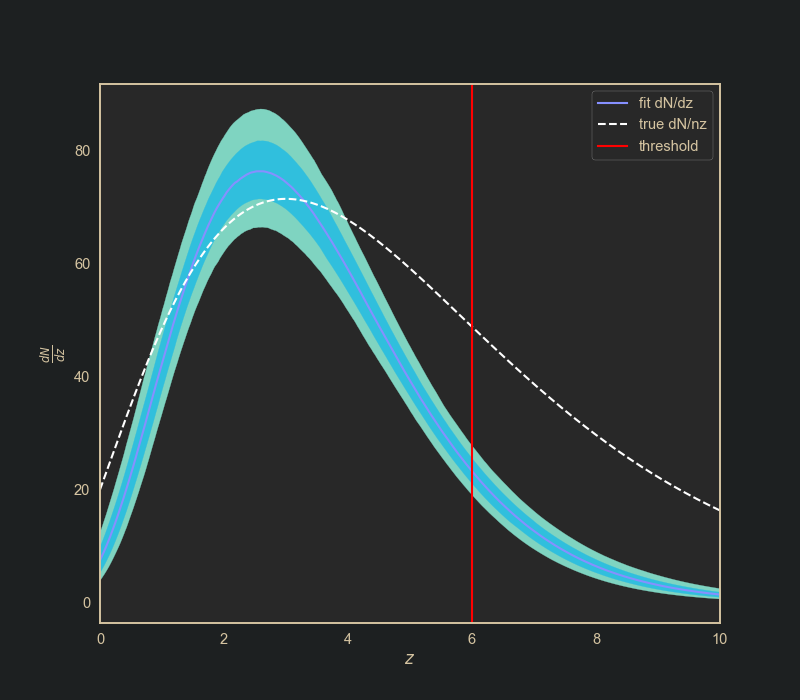

In [48]:
fig, ax = plt.subplots()
mallsoft = vapeplot.palette("mallsoft")



ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 97.5, axis=0), np.percentile(chain_selected['dNdz_model'], 2.5, axis=0), color=mallsoft[-1], alpha=1)
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 84, axis=0), np.percentile(chain_selected['dNdz_model'], 16, axis=0), color=mallsoft[-2], alpha=1)
ax.plot(zmodel, np.median(chain_selected['dNdz_model'], axis=0),color=mallsoft[-3],label='fit dN/dz')
ax.plot(zmodel, dNdz(zmodel, 20., 2., 2.), '--', color='white',label='true dN/nz')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\frac{dN}{dz}$')
ax.grid(False)

ax.axvline(6,color='red',label='threshold')
ax.set_xlim(0,10)
ax.legend()

#fig.savefig('final.pgf')

In [38]:
fit

Inference for Stan model: flux_fit_f89ebf10f4c72f54bd1bd878b59da912.
4 chains, each with iter=4000; warmup=2000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r0                8.13    0.16   2.31   4.35   6.46   7.94   9.56  13.27    218   1.01
alpha             4.06    0.03   0.43   3.26   3.76   4.04   4.35   4.97    196   1.01
beta              0.89  5.7e-3   0.08   0.74   0.84   0.89   0.95   1.06    206   1.01
mu                1.44  3.8e-4 7.8e-3   1.42   1.43   1.44   1.44   1.45    428    1.0
sigma             0.14  2.4e-4 5.2e-3   0.13   0.14   0.14   0.15   0.15    477    1.0
ztrue[0]          2.68  8.4e-3   0.14   2.43   2.59   2.68   2.77   2.97    274   1.02
ztrue[1]           1.1  2.0e-3   0.05    1.0   1.06   1.09   1.13    1.2    653   1.01
ztrue[2]          3.12  6.6e-3   0.16   2.82   3.02   3.11   3.22   3.43    548    1.0
ztrue[3]          6.62    0.01